In [14]:
from pathlib import Path
from datetime import date
from trout.stars import Star

from sklearn.linear_model import HuberRegressor

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [15]:
root = Path(".")

def make_color_logfile_name(color:str, date:date, img_dur:float, img_no:str="001"):
    return date.strftime(f"%m-%d-%y_m23_{color}_{img_dur}-{img_no}.txt")

def get_color_logfile_df(color:str, date:date):
    color_folder = root / color
    if not color_folder.exists():
        raise ValueError("Can't find color folder for", color)
    img_durations = {"b":20.0, "v":10.0, "r":10.0, "i":10.0}
    file_name = make_color_logfile_name(color, date, img_durations[color], "001")
    file = color_folder / file_name
    if not file.exists():
        raise ValueError(f"File {file} doesn't exist")
    df = pd.read_csv(file, delimiter=r"\s{2,}", engine="python", skiprows=8)
    df.index = range(1, len(df.index) + 1)
    df.index.name = "star"
    return df

In [16]:
aug_20 = date(2006, 8, 20)
aug_22 = date(2006, 8, 22)

In [17]:
# Blue
df_20_b = get_color_logfile_df("b", aug_20)
# Visual
df_20_v = get_color_logfile_df("v", aug_20)
df_22_v = get_color_logfile_df("v", aug_22)
# Red
df_20_r = get_color_logfile_df("r", aug_20)
df_22_r = get_color_logfile_df("r", aug_22)
# Infrared
df_20_i = get_color_logfile_df("i", aug_20)
df_22_i = get_color_logfile_df("i", aug_22)

In [18]:
dfs_color_date = {
    "20b": df_20_b,
    "20v": df_20_v,
    "20r": df_20_r,
    "20i": df_20_i,
    
    "22v": df_22_v,
    "22r": df_22_r,
    "22i": df_22_i,
}

In [19]:
# Preview
df_20_b

,X,Y,XFWHM,YFWHM,Avg FWHM,Sky ADU,Star ADU 3,Star ADU 4,Star ADU 5
star,,,,,,,,,
1,746.17,459.15,3.1819,2.7025,2.9422,449.72,908244.81,974211.00,992572.68
2,547.01,493.79,2.5403,2.2612,2.4007,439.63,176977.00,183791.70,185665.12
3,462.53,523.01,2.5794,2.4136,2.4965,443.70,134594.87,142155.09,144145.72
4,230.51,347.41,2.9507,2.7414,2.8460,458.13,122477.27,131443.88,134284.50
5,112.14,420.22,3.3562,2.8977,3.1270,449.23,149464.46,163448.14,168661.85
...,...,...,...,...,...,...,...,...,...
3741,780.13,781.18,0.0000,4.8626,2.4313,456.05,117.63,94.48,1.75
3742,864.51,760.85,0.0000,14.2425,7.1213,456.43,-74.90,-1.27,237.34
3743,292.45,650.74,0.0000,6.8628,3.4314,447.84,135.24,219.10,306.34


In [20]:
def make_fwhm_chart(df, title=""):
    df_filtered = df[(df["XFWHM"] > 0) & (df["YFWHM"] > 0) & (df["Star ADU 4"] > 0)]
    plt.scatter(df_filtered["X"], df_filtered["XFWHM"])
    plt.title(title)
    plt.show()

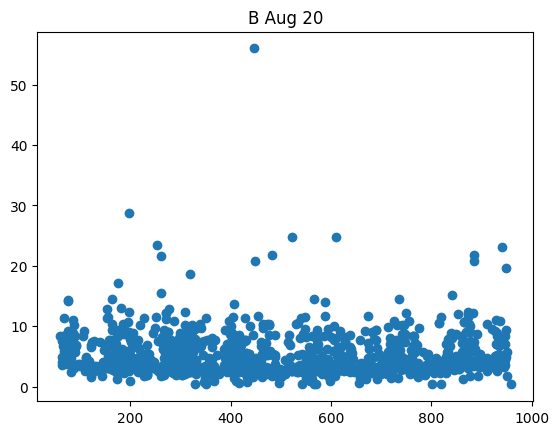

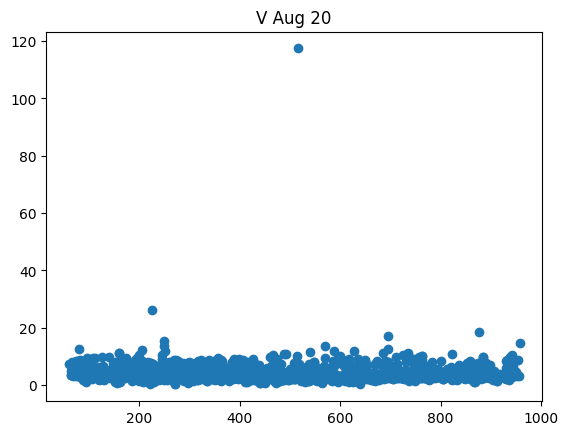

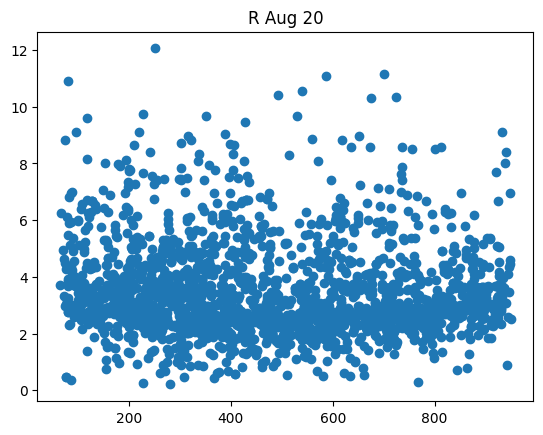

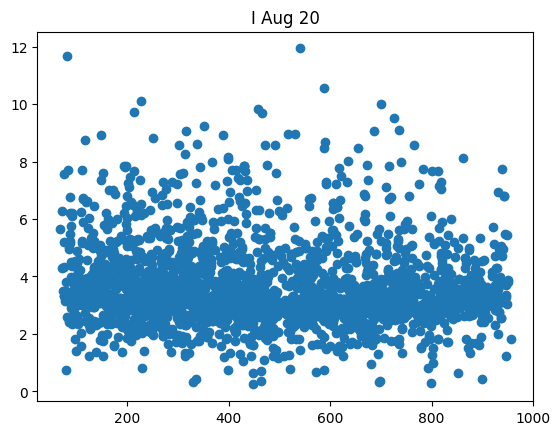

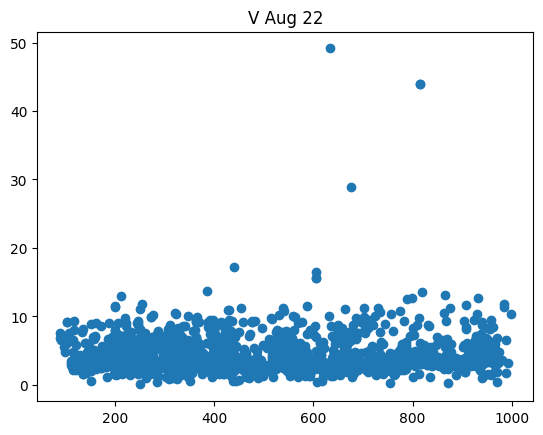

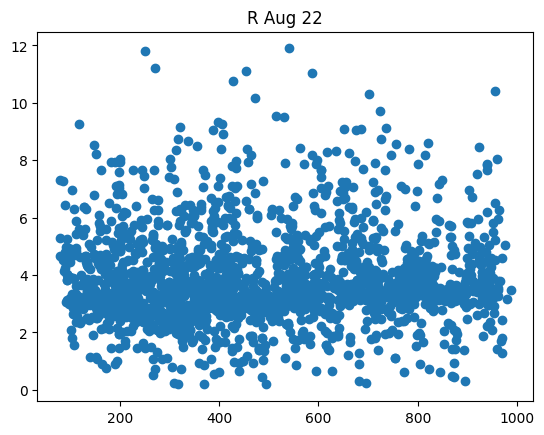

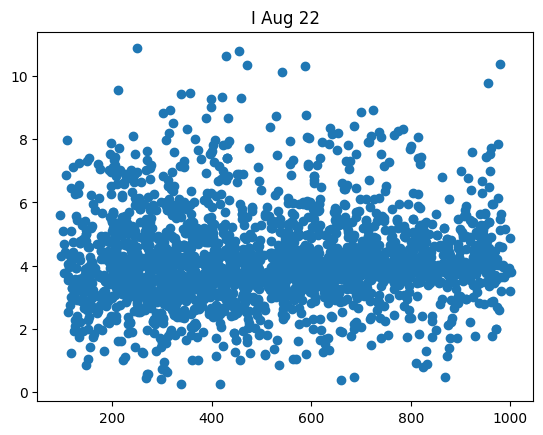

In [21]:
make_fwhm_chart(df_20_b, "B Aug 20")
make_fwhm_chart(df_20_v, "V Aug 20")
make_fwhm_chart(df_20_r, "R Aug 20")
make_fwhm_chart(df_20_i, "I Aug 20")

make_fwhm_chart(df_22_v, "V Aug 22")
make_fwhm_chart(df_22_r, "R Aug 22")
make_fwhm_chart(df_22_i, "I Aug 22")

In [22]:
# Read existing color data to normalize against
df_color_std = pd.read_csv("./2006_color_data_with_2508_stars_result.tsv", delimiter="\t", index_col=0)
df_color_std.index.name = "star"

In [23]:
df_color_std.columns

Index(['20r', '20i', '20r-20i', 'E', '22r', '22i', '22r-22i', 'mean r-i',
       '22b', '22v', '22b-22v', 'M', '20b', '20v', '20b-20v', 'Q',
       'catalogue v', 'catalogue b-v', 'catalogue b', 'U', 'catalogue v - 22v',
       'catalogue v - 20v', 'X', 'catalogue b - 22b', 'catalogue b - 20b',
       '22v-20v'],
      dtype='object')

In [24]:
def get_star_to_normalize_to(color_date_str, radius=4):
    if color_date_str not in dfs_color_date.keys():
        raise ValueError(f"Cant find df for {color_date_str}")
        
    candidates = df_color_std[df_color_std[color_date_str] > 0].index.values
    # Only use stars within 1-200 range
    candidates = list(filter(lambda x: x < 200, candidates)) 
    df = dfs_color_date[color_date_str].loc[candidates]
    df = df[df[f"Star ADU {radius}"] > 0]
    return df.index.values
    
stars_to_normalize_to = {
    color_date_str: get_star_to_normalize_to(color_date_str) for color_date_str in dfs_color_date.keys()
}

In [12]:
def std_mag_vs_log_adu_chart(color_date_str:str, radius=4, display_chart=False):
    if color_date_str not in dfs_color_date.keys():
        raise ValueError("Invalid color date str. Valid options are " + ", ".join(dfs.keys()))
    color_df, stars_to_normalize = dfs_color_date[color_date_str], stars_to_normalize_to[color_date_str]
    
    # X
    adu_log = np.log(color_df.loc[stars_to_normalize][f"Star ADU {radius}"])
    # Y
    std_mags = df_color_std.loc[stars_to_normalize][color_date_str]
    
    if display_chart:
        plt.scatter(adu_log, std_mags)
        plt.xlabel(f"log(ADU) {radius}px extraction")
        plt.ylabel("Standard Magnitude")
        plt.title(color_date_str)
        print(color_date_str)
        print("Stars used", stars_to_normalize)
    
    epsilon=1
    huber = HuberRegressor(alpha=0.0, epsilon=epsilon)

    x = np.linspace(adu_log.min(), adu_log.max(), 7)

    huber.fit(adu_log.values.reshape(-1,1), std_mags.values.reshape(-1, 1))
    coef_ = huber.coef_ * x + huber.intercept_
    if display_chart:
        plt.plot(x, coef_, "r", label="huber loss, %s" % epsilon)

    plt.show()
    
    def get_magnitude_for_star(star_no):
        adu = color_df.loc[star_no][f"Star ADU {radius}"]
        if adu > 0:
            return huber.coef_ * np.log(adu) + huber.intercept_
        else:
            return [np.nan]
    return get_magnitude_for_star

20b
Stars used [  1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18  21
  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  65  66  68  69  71  72  73  74  75  76  77  78  79  80  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 101
 102 103 104 106 108 109 110 112 113 114 116 117 118 119 120 121 122 123
 124 125 128 129 130 133 134 136 137 138 140 141 142 143 145 146 147 149
 150 152 153 154 155 156 157 158 159 160 163 164 165 166 167 168 170 171
 172 173 174 176 178 180 181 182 184 185 186 187 189 190 193 194 195 196
 197 198 199]


/opt/tljh/user/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


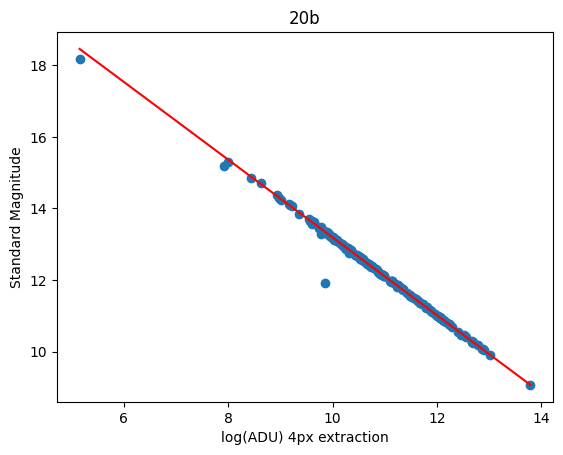

20b
Stars used [  1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18  21
  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  65  66  68  69  71  72  73  74  75  76  77  78  79  80  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 101
 102 103 104 106 108 109 110 112 113 114 116 117 118 119 120 121 122 123
 124 125 128 129 130 133 134 136 137 138 140 141 142 143 145 146 147 149
 150 152 153 154 155 156 157 158 159 160 163 164 165 166 167 168 170 171
 172 173 174 176 178 180 181 182 184 185 186 187 189 190 193 194 195 196
 197 198 199]


/opt/tljh/user/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


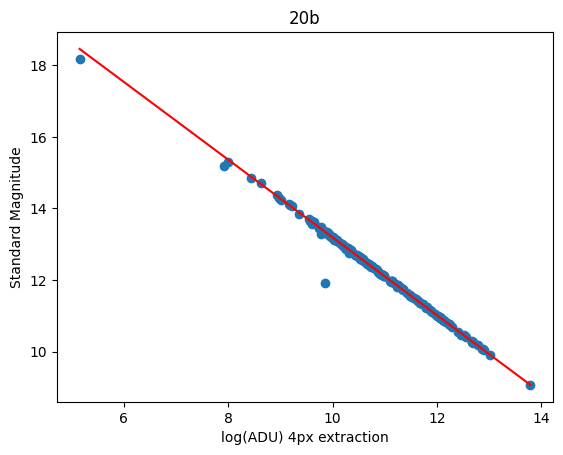

20r
Stars used [  1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18  19
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  39
  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  60  61  62  65  66  68  69  71  72  73  74  75  76  77  78  79  80  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 101
 102 103 104 106 108 109 110 112 113 114 115 116 117 118 119 120 121 122
 123 124 125 126 128 129 130 133 134 136 137 138 140 141 142 143 145 146
 147 149 150 152 153 154 155 156 157 158 159 160 163 164 165 166 167 168
 170 171 172 173 174 176 178 180 181 182 184 185 186 187 189 190 193 194
 195 196 197 198 199]


/opt/tljh/user/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


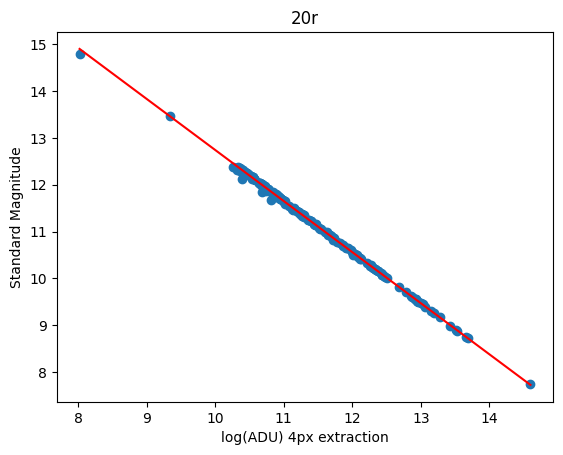

20i
Stars used [  1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18  21
  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  65  66  68  69  71  72  73  74  75  76  77  78  79  80  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  99 101 102
 103 104 106 108 109 110 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 128 129 130 133 134 136 137 138 140 141 142 143 145 146 147
 149 150 152 153 154 155 156 157 158 159 160 163 164 165 166 167 168 170
 171 172 173 174 176 178 180 181 182 184 185 186 187 189 190 193 194 195
 196 197 198 199]


/opt/tljh/user/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


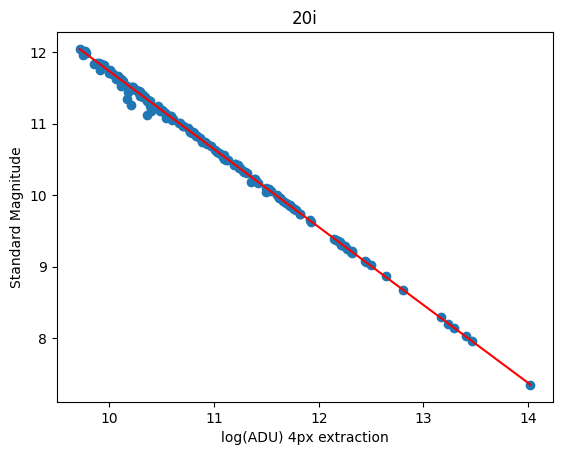

22v
Stars used [  1   2   3   4   6   7   8   9  10  11  12  13  15  16  17  18  21  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  39  40  41
  42  43  44  45  46  47  48  49  50  51  53  54  55  56  57  59  60  61
  62  64  65  66  68  69  71  72  73  74  75  76  77  78  79  80  82  83
  85  86  87  88  89  90  91  92  93  94  95  96  98  99 101 102 103 104
 106 108 109 110 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 133 134 137 138 140 141 142 143 145 146 147 149 150
 152 153 154 155 156 157 158 159 160 163 164 165 166 167 168 170 171 172
 174 176 178 179 180 181 182 184 185 186 187 189 190 193 194 195 196 198
 199]


/opt/tljh/user/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


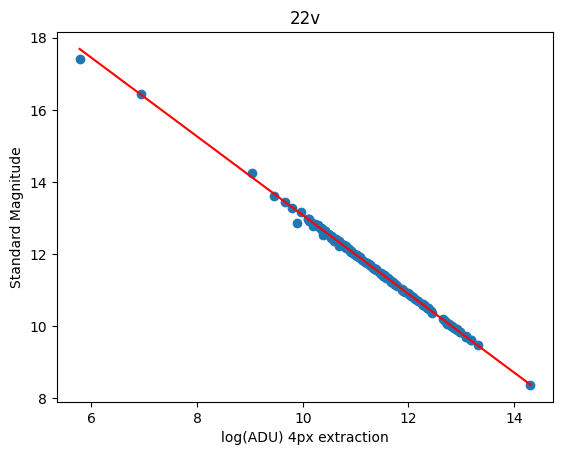

22r
Stars used [  1   2   3   4   5   7   8   9  10  11  12  13  14  15  16  17  18  21
  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  65  66  68  69  70  71  72  73  74  75  76  77  78  79  80
  82  83  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 101
 102 103 104 106 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 133 134 137 138 140 141 142 143 145
 146 147 149 150 152 153 154 155 156 157 158 159 160 163 164 165 166 167
 168 170 171 172 173 174 175 176 177 178 180 181 182 184 185 186 187 189
 190 193 194 195 196 197 198 199]


/opt/tljh/user/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


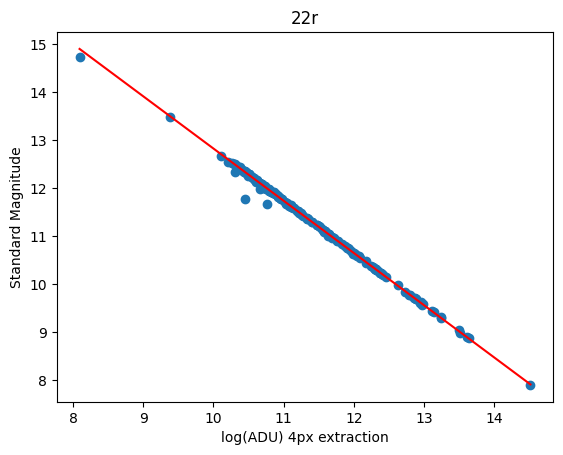

22i
Stars used [  1   2   3   4   6   8   9  10  11  12  13  14  15  16  17  18  21  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  39  40  41
  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59  60
  61  62  64  65  66  68  69  71  72  73  74  75  76  77  78  79  80  82
  83  85  86  87  88  89  90  91  92  93  94  95  96  98  99 101 102 103
 104 106 108 109 110 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 128 129 130 133 134 137 138 140 141 142 143 145 146 147 149 150
 152 153 154 155 156 157 158 159 160 163 164 165 166 167 168 170 171 172
 173 174 176 178 179 180 181 182 184 185 186 187 189 190 193 194 195 196
 198 199]


/opt/tljh/user/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


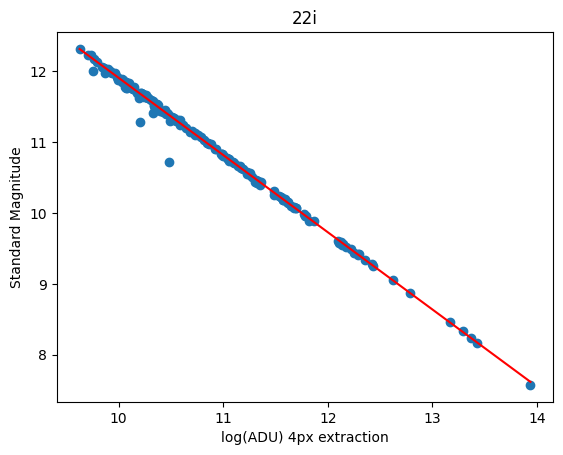

<function __main__.std_mag_vs_log_adu_chart.<locals>.get_magnitude_for_star(star_no)>

In [25]:
std_mag_vs_log_adu_chart("20b", display_chart=True)
std_mag_vs_log_adu_chart("20b", display_chart=True)
std_mag_vs_log_adu_chart("20r", display_chart=True)
std_mag_vs_log_adu_chart("20i", display_chart=True)

std_mag_vs_log_adu_chart("22v", display_chart=True)
std_mag_vs_log_adu_chart("22r", display_chart=True)
std_mag_vs_log_adu_chart("22i", display_chart=True)

In [26]:
new_colors_dict = {star: {} for star in range(1, 3746)}
for date_color_str in dfs_color_date.keys():
    fn = std_mag_vs_log_adu_chart(date_color_str)
    for star in new_colors_dict:
        new_colors_dict[star][date_color_str] = fn(star)[0]

/opt/tljh/user/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/tljh/user/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/tljh/user/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/tljh/user/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

In [27]:
new_colors_df = pd.DataFrame.from_dict(new_colors_dict, orient="index")
new_colors_df.index.name = "star"

new_colors_df["20r-20i"] = new_colors_df["20r"] - new_colors_df["20i"]
new_colors_df["22r-22i"] = new_colors_df["22r"] - new_colors_df["22i"]

new_colors_df["mean r-i"] = new_colors_df[["20r-20i", "22r-22i"]].mean(axis=1)

In [29]:
new_colors_df

,20b,20v,20r,20i,22v,22r,22i,20r-20i,22r-22i,mean r-i
star,,,,,,,,,,
1,9.066399,8.288129,7.725509,7.348463,8.373287,7.907150,7.617917,0.377046,0.289233,0.333139
2,10.879766,9.554979,8.714430,8.020839,9.606042,8.869063,8.240756,0.693591,0.628307,0.660949
3,11.159067,9.681847,8.751804,7.961900,9.712814,8.893800,8.173392,0.789904,0.720408,0.755156
4,11.244242,9.808153,8.913927,8.139909,9.831823,9.022652,8.316919,0.774019,0.705733,0.739876
5,11.007310,9.714823,8.895847,8.206589,9.730521,9.003327,8.386003,0.689258,0.617325,0.653292
...,...,...,...,...,...,...,...,...,...,...
3741,19.113806,18.856602,17.071997,16.151406,17.594936,16.898968,16.615780,0.920591,0.283188,0.601889
3742,NaN,17.127467,16.383674,14.463917,18.593205,16.423425,14.600042,1.919757,1.823383,1.871570
3743,18.199264,19.044442,18.452688,16.087733,NaN,17.577578,17.780122,2.364955,-0.202543,1.081206


In [28]:
new_colors_df.to_csv("new_colors.txt", sep="\t")